In [1]:
#Importing packages
import sys
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import string
import matplotlib.pyplot as plt
import pickle

from pprint import pprint
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud

/Users/alchemist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/alchemist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/alchemist/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/alchemist/anaconda3/lib/python3.7/site-packages/tensorflow/pyth

In [2]:
#Importing data 
twenty_train = fetch_20newsgroups(subset='train', random_state = 42,shuffle=True, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', random_state = 42, shuffle=True, remove=('headers', 'footers', 'quotes'))

# Step 1:  Explanatory Data Analysis#

In [3]:
print("Categories names are:\n")
for i in twenty_train.target_names:
    print(i)
print("\n Total:{}".format(len(twenty_train.target_names)))

Categories names are:

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc

 Total:20


In [4]:
print("Length of the training data set is {}".format(len(twenty_train.data))) 
print("Length of the test data set is {}".format(len(twenty_test.data))) 
print("Length of the total dataset is {}".format(11314+7532))

Length of the training data set is 11314
Length of the test data set is 7532
Length of the total dataset is 18846


In [5]:
names = []
test_names = []
for i in twenty_train.target:
    names.append(twenty_train.target_names[i])
for i in twenty_test.target:
    test_names.append(twenty_test.target_names[i])

In [6]:
df_train = pd.DataFrame(data = np.c_[twenty_train.data,twenty_train.target,names] , columns = ("Text","Target_id","Target_name"))
df_test  = pd.DataFrame(data = np.c_[twenty_test.data,twenty_test.target,test_names] , columns = ("Text","Target","Target_name"))

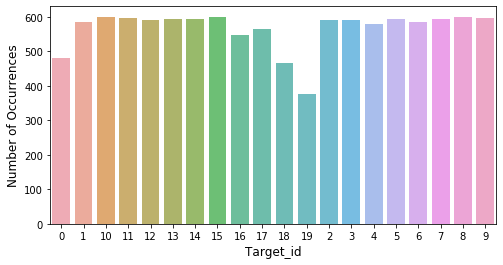

In [7]:
#Are the classes balanced? 
count_target = df_train['Target_id'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count_target.index,  count_target.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Target_id', fontsize=12)
plt.show()

Above plot shows that the classes are little unbalanced. News reports from categories 'comp.graphics', 'talk.politics.misc' & 'talk.religion.misc' are fewer compared to other categories. 

# Examine the properties by target#

In [8]:
###Adding extra features 
def add_features(df):
    df['Length_of_text'] = df['Text'].apply(lambda x: len(str(x))) # length of each text
    df['unique'] = df['Text'].apply(lambda x: len(set(str(x)))) # Unique characters
    df['punctuations'] = df['Text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    df['uniq_punctuations'] = df['Text'].apply(lambda x: len(set([c for c in str(x) if c in string.punctuation])))
    df['letters'] = df['Text'].apply(lambda x: len([c for c in str(x) if c.isalpha()])) 
    df['uniq_letters'] = df['Text'].apply(lambda x: len(set([c for c in str(x) if c.isalpha()])))
    df['numbers'] = df['Text'].apply(lambda x: len([c for c in str(x) if c.isdigit()]))
    df['uniq_numbers'] = df['Text'].apply(lambda x: len(set([c for c in str(x) if c.isdigit()])))
    df['uppercase'] = df['Text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
    df['uniq_uppercase'] = df['Text'].apply(lambda x: len(set([c for c in str(x) if c.isupper()])))
    df['lowercase'] = df['Text'].apply(lambda x: len([c for c in str(x) if c.islower()]))
    df['uniq_lowercase'] = df['Text'].apply(lambda x: len(set([c for c in str(x) if c.islower()])))

In [9]:
add_features(df_train)
add_features(df_test)

<Figure size 864x864 with 0 Axes>

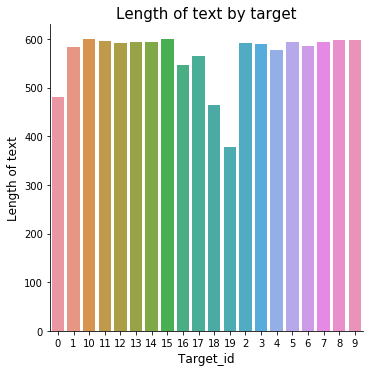

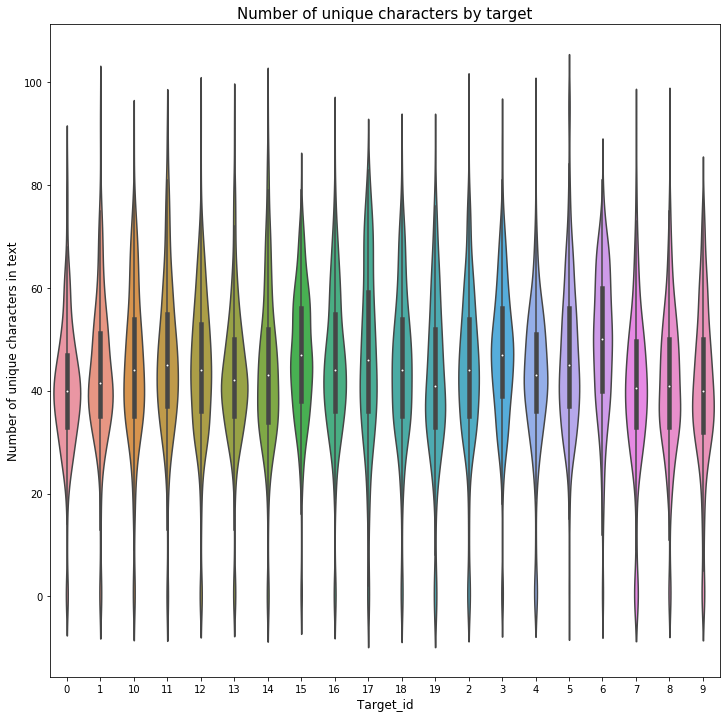

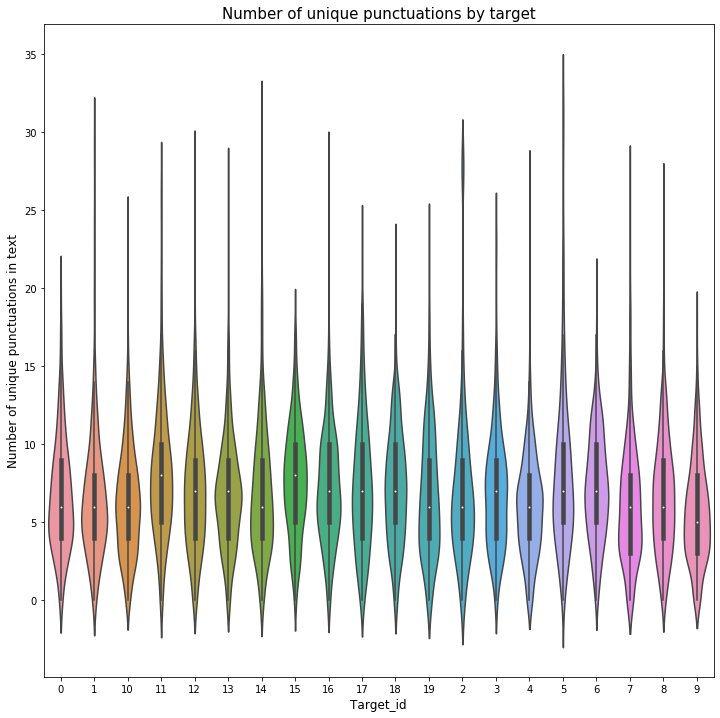

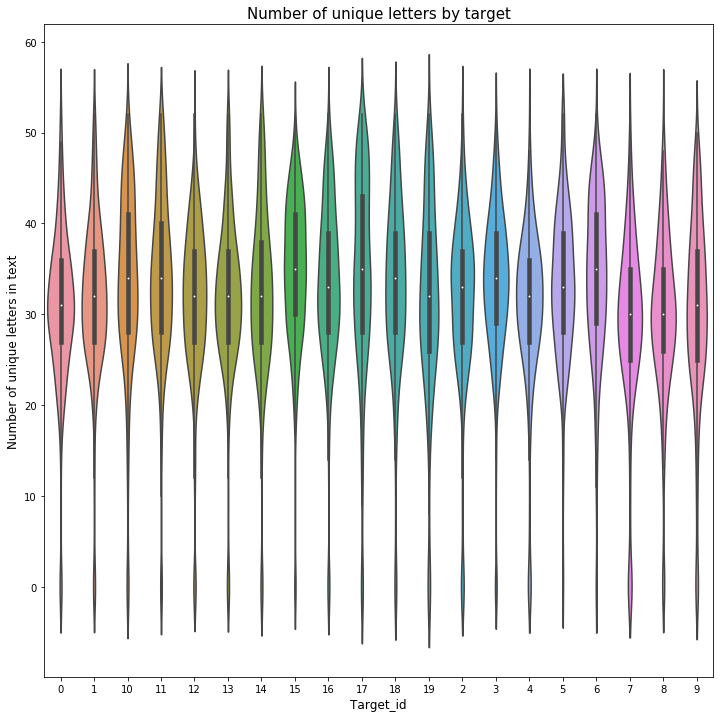

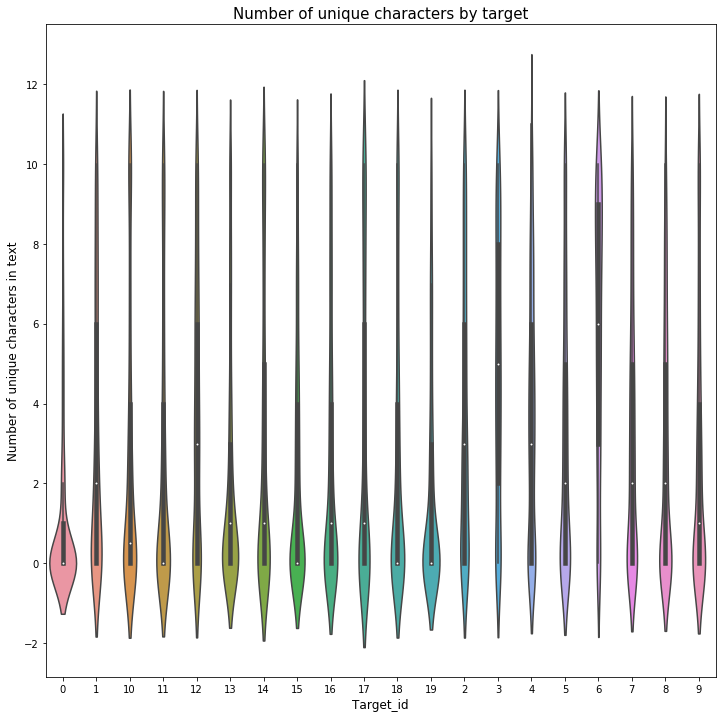

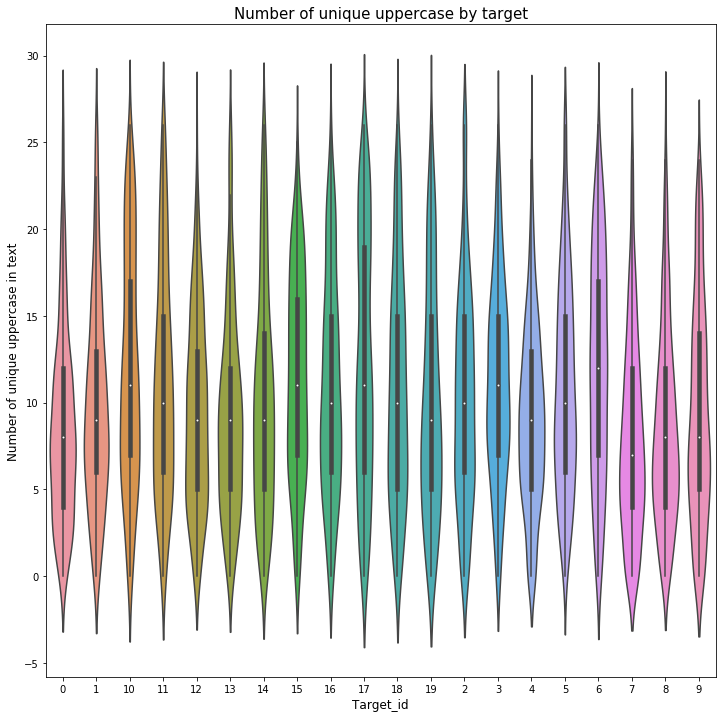

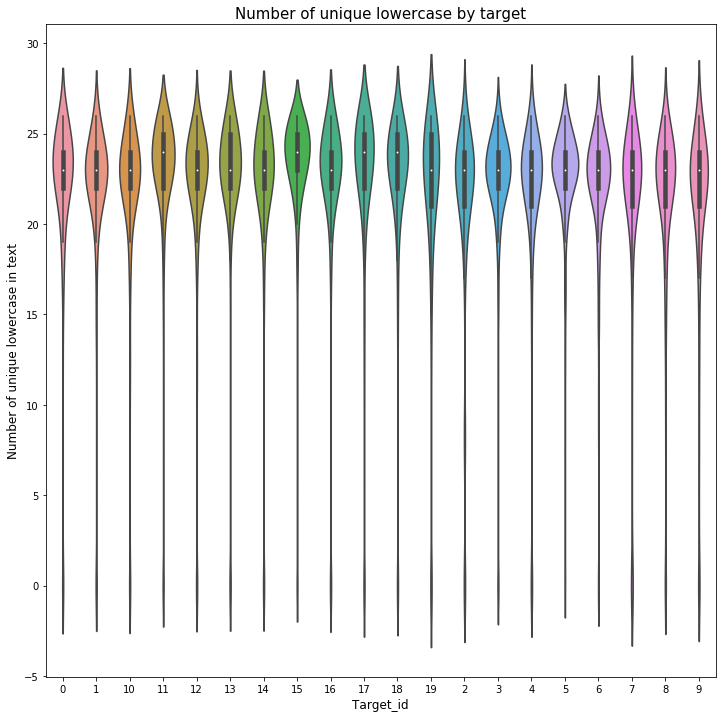

In [10]:
plt.figure(figsize=(12,12))
sns.catplot(x='Target_id', data=df_train,kind="count")
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Length of text', fontsize=12)
plt.title("Length of text by target", fontsize=15)
plt.show()
###########
plt.figure(figsize=(12,12))
sns.violinplot(x='Target_id', y='unique', data=df_train)
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Number of unique characters in text', fontsize=12)
plt.title("Number of unique characters by target", fontsize=15)
plt.show()
###########
plt.figure(figsize=(12,12))
sns.violinplot(x='Target_id', y='uniq_punctuations', data=df_train)
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Number of unique punctuations in text', fontsize=12)
plt.title("Number of unique punctuations by target", fontsize=15)
plt.show()
###########
plt.figure(figsize=(12,12))
sns.violinplot(x='Target_id', y='uniq_letters', data=df_train)
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Number of unique letters in text', fontsize=12)
plt.title("Number of unique letters by target", fontsize=15)
plt.show()
###########
plt.figure(figsize=(12,12))
sns.violinplot(x='Target_id', y='uniq_numbers', data=df_train)
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Number of unique characters in text', fontsize=12)
plt.title("Number of unique characters by target", fontsize=15)
plt.show()
###########
plt.figure(figsize=(12,12))
sns.violinplot(x='Target_id', y='uniq_uppercase', data=df_train)
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Number of unique uppercase in text', fontsize=12)
plt.title("Number of unique uppercase by target", fontsize=15)
plt.show()
###########
plt.figure(figsize=(12,12))
sns.violinplot(x='Target_id', y='uniq_lowercase', data=df_train)
plt.xlabel('Target_id', fontsize=12)
plt.ylabel('Number of unique lowercase in text', fontsize=12)
plt.title("Number of unique lowercase by target", fontsize=15)
plt.show()
###########

In [11]:
print("Printing first post to explore \n")
print("\n".join(df_train['Text'][0].split("\n")[:])) #prints first line of the first data file
print("\n Above post belongs to {}".format(df_train.Target_name[0]))

Printing first post to explore 

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

 Above post belongs to rec.autos


In [12]:
df_train.columns

Index(['Text', 'Target_id', 'Target_name', 'Length_of_text', 'unique',
       'punctuations', 'uniq_punctuations', 'letters', 'uniq_letters',
       'numbers', 'uniq_numbers', 'uppercase', 'uniq_uppercase', 'lowercase',
       'uniq_lowercase'],
      dtype='object')

# Cleaning text

In [13]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags,  #Unicode string without tags.
           gsp.strip_punctuation, #Unicode string without punctuation characters.
           gsp.strip_multiple_whitespaces, #Unicode string without repeating in a row whitespace characters.
           gsp.strip_numeric, #Unicode string without digits.
           gsp.remove_stopwords, #Unicode string without STOPWORDS.
           gsp.strip_short, #Unicode string without short words.
           #gsp.stem_text #Unicode lowercased and porter-stemmed version of string text.
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

In [14]:
########################
def show_top10(classifier, vectorizer, categories):
    feature_names = np.asarray(vectorizer.get_feature_names())
    for i, category in enumerate(categories):
        top10 = np.argsort(classifier.coef_[i])[-10:]
        print("{}: {}".format(category, " ".join(feature_names[top10])))
######################
vectorizer = TfidfVectorizer() #vectorizer
vectors = vectorizer.fit_transform(df_train.Text)
clf = MultinomialNB(alpha=.01) #classifier
clf.fit(vectors, twenty_train.target)
print("Number of features in the datset are {} \n \n".format(np.shape(vectors)[1])) 

#########################
print("Display first 10 features for each category \n")
show_top10(clf, vectorizer, twenty_train.target_names)

Number of features in the datset are 69159 
 

Display first 10 features for each category 

alt.atheism: know objective bible islam atheists religion atheism think people god
comp.graphics: need looking format know program file files thanks image graphics
comp.os.ms-windows.misc: card thanks win use driver drivers files dos file windows
comp.sys.ibm.pc.hardware: monitor drives disk thanks ide controller bus card scsi drive
comp.sys.mac.hardware: know centris monitor quadra problem simms thanks drive apple mac
comp.windows.x: display windows xterm application use thanks widget server motif window
misc.forsale: interested email asking sell price condition new shipping offer sale
rec.autos: know oil ford new good dealer engine like cars car
rec.motorcycles: bmw know helmet riding like motorcycle ride bikes dod bike
rec.sport.baseball: braves players pitching hit runs games game baseball team year
rec.sport.hockey: league year nhl players season play games hockey team game
sci.crypt: peop

We can see that, all the features are only words. 

# Exploring data using word cloud

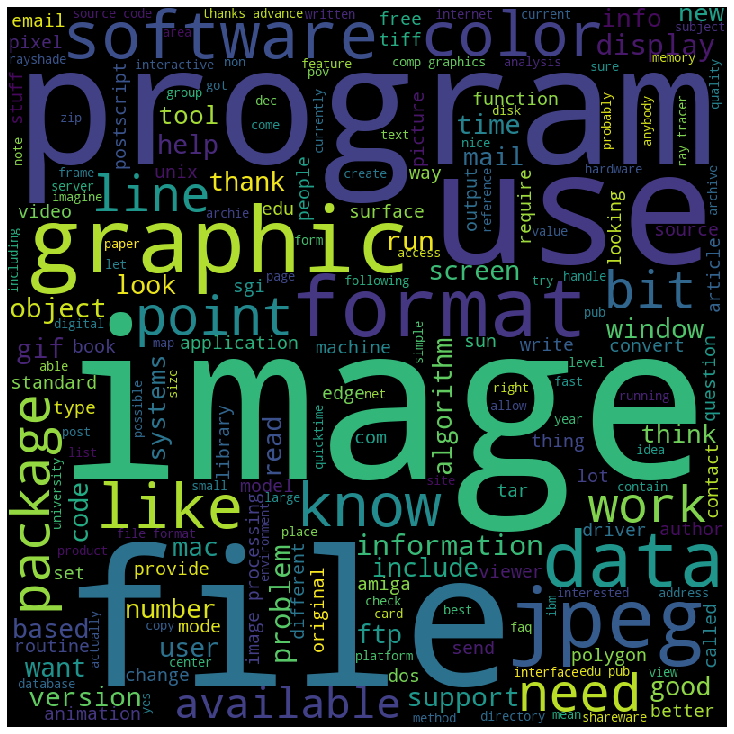

In [15]:
def plot_word_cloud(text):
    wordcloud_instance = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords='english',
                min_font_size = 5).generate(text) 
             
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud_instance) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def plot_word_cloud_for_cat(category):
    text_df = df_train.loc[df_train['Target_name'] == str(category)]
    texts = ''
    for index, item in text_df.iterrows():
        texts = texts + ' ' + clean_text(item['Text'])
    plot_word_cloud(texts)

plot_word_cloud_for_cat('comp.graphics')

# Multi-nominal Naive bayesian classifier

In [16]:
#Multi-nominal Naive bayesian classifier
mulit_nb_clf = Pipeline([
      ('vect', CountVectorizer(stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('clf', MultinomialNB(fit_prior=False)), 
            ])

parameters = {'vect__max_df': (0.5,0.75,1.0),
              'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3)}

gs_clf = GridSearchCV(mulit_nb_clf, parameters,n_jobs=-1)
gs_clf = gs_clf.fit(df_train.Text,df_train.Target_id)

# save the model to disk
filename = 'mulit_nb_clf.sav'
pickle.dump(gs_clf, open(filename, 'wb'))

/Users/alchemist/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [17]:
filename = 'mulit_nb_clf.sav'
# load the model from disk
#gs_clf = pickle.load(open(filename, 'rb'))

predicted = gs_clf.predict(df_test.Text)
print("Accuracy using Naive Bayes Classifier, with help of gridsearch is {} %".format(np.mean(predicted == df_test.Target)*100)) 

Accuracy using Naive Bayes Classifier, with help of gridsearch is 70.10090281465746 %


In [18]:
gs_clf.best_score_ # mean cross-validated score of the estimator on the training dataset
gs_clf.best_params_

{'clf__alpha': 0.01,
 'tfidf__use_idf': True,
 'vect__max_df': 0.5,
 'vect__ngram_range': (1, 2)}

In [19]:
#linear SVM
sgd_clf = Pipeline([
      ('vect', CountVectorizer(stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',random_state=42)), 
            ])
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf-svm__alpha': (1e-2, 1e-3)}
sgd_clf = GridSearchCV(sgd_clf, parameters,n_jobs=-1)
sgd_clf = sgd_clf.fit(df_train.Text,df_train.Target_id)

filename = 'sgd_clf.sav'
pickle.dump(sgd_clf, open(filename, 'wb'))

/Users/alchemist/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [20]:
filename = 'sgd_clf.sav'
# load the model from disk
#sgd_clf = pickle.load(open(filename, 'rb'))

predicted = sgd_clf.predict(df_test.Text)

In [21]:
sgd_clf.best_score_

0.7457138302598251

In [22]:
print("Accuracy using SGDClassifier, on test datset is {} %".format(np.mean(predicted == df_test.Target)*100))

Accuracy using SGDClassifier, on test datset is 68.41476367498672 %


In [38]:
###SVC
from sklearn import svm
svc_clf = Pipeline([
      ('vect', CountVectorizer(stop_words='english')),
      ('tfidf', TfidfTransformer()),
      ('svc_clf', svm.SVC()), 
            ])

parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False)}
svc_clf = GridSearchCV(svc_clf, parameters,n_jobs=-1)

svc_clf = svc_clf.fit(df_train.Text,df_train.Target_id)

filename = 'svc_clf.sav'
pickle.dump(svc_clf, open(filename, 'wb'))

In [39]:
filename = 'svc_clf.sav'
# load the model from disk
#svc_clf = pickle.load(open(filename, 'rb'))

predicted = svc_clf.predict(df_test.Text)

In [40]:
print("Accuracy using SVC Classifier, on test datset is {} %".format(np.mean(predicted == df_test.Target)*100))

Accuracy using SVC Classifier, on test datset is 67.37918215613384 %


In [33]:
###random forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
      ('vect', CountVectorizer(stop_words='english')),
      ('tfidf', TfidfTransformer(use_idf=True)),
      ('clf_rf', RandomForestClassifier(n_estimators=100, 
                               random_state=46, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)), 
            ])

In [34]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)]}
rf_clf = GridSearchCV(rf_clf, parameters,n_jobs=-1)
rf_clf = rf_clf.fit(df_train.Text,df_train.Target_id)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished


In [35]:

filename = 'rf_clf.sav'
pickle.dump(rf_clf, open(filename, 'wb'))
# load the model from disk
#rf_clf = pickle.load(open(filename, 'rb'))

predicted = rf_clf.predict(df_test.Text)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [37]:
print("Accuracy using random forest Classifier, with help of gridsearch is {} %".format(np.mean(predicted == df_test.Target)*100)) 

Accuracy using random forest Classifier, with help of gridsearch is 61.09930961232076 %


In [41]:
print(classification_report(df_test.Target, predicted, target_names=twenty_train.target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.49      0.46      0.48       319
           comp.graphics       0.57      0.71      0.63       389
 comp.os.ms-windows.misc       0.94      0.82      0.88       399
comp.sys.ibm.pc.hardware       0.93      0.64      0.76       396
   comp.sys.mac.hardware       0.45      0.66      0.53       393
          comp.windows.x       0.73      0.77      0.75       396
            misc.forsale       0.66      0.76      0.71       394
               rec.autos       0.65      0.78      0.71       398
         rec.motorcycles       0.58      0.68      0.63       364
      rec.sport.baseball       0.89      0.71      0.79       376
        rec.sport.hockey       0.57      0.45      0.51       310
               sci.crypt       0.64      0.15      0.25       251
         sci.electronics       0.69      0.57      0.62       394
                 sci.med       0.66      0.63      0.65       392
         

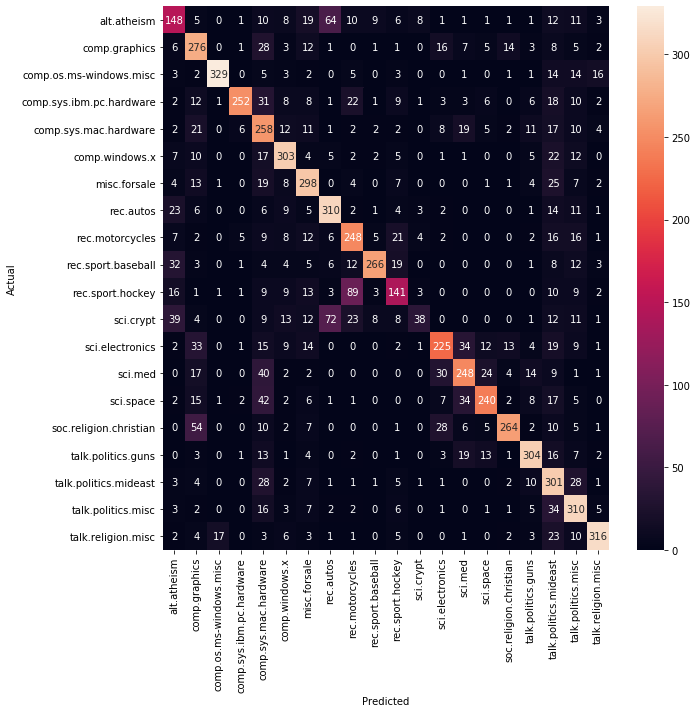

In [42]:
# Plot the confusion matrix
cm = metrics.confusion_matrix(df_test.Target, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=twenty_train.target_names, yticklabels=twenty_train.target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
plt.show()

In [ ]:
# plot_word_cloud_for_cat('rec.sport.hockey') 
# plot_word_cloud_for_cat('rec.motorcycles') 

# NOTES

#(Short) Literature overview: 

Q) Which were some of the first approaches? 
Q) How well did they perform and why? 

	The training as well as test dataset was imported using fetch_20newsgroups from sklearn dataset. This dataset is one of the classical dataset for experiments in text applications of machine learning techniques, such as text classification and text clustering. It contains around 18,000 posts belonging to 20 different categories. The training dataset are the posts before a particular date and test dataset posts are ones after the date. The goal here is to use machine learning to classify new posts (from test dataset). 
	After importing the dataset in the Jupiter notebook, first the length of the datasets were checked. Training size is around 60% (11,314) of the total dataset, which is good enough to begin training with. It is also seen that the dataset is not completely balanced. News reports from categories 'comp.graphics', 'talk.politics.misc' & 'talk.religion.misc' are fewer compared to other categories. Overall,  the number of articles for each news group given is roughly uniform. (In case of imbalanced classes confusion-matrix is good technique to summarising the performance of a classification algorithm.)
       Counter vectoriser was used, which builds a dictionary of features and transforms documents to feature vector. The number of features in the dataset are 101322.  
       First classifier to use a Multinominal Naive bayesian classifier. This was chosen as it is well known for text classification. Accuracy on the test dataset of around ~77% was noted. To improve the accuracy, grid search for the parameters was done. The test dataset accuracy is around ~82%.  

#Data exploration: 

Q) What are the most prominent labels in the corpus, which ones are particularly rare? Any idea why?

Q) Is there something that strikes the eye? Are there any curious findings?

Q) What are some methods to visualize / explore textual data? If you find good examples, please name or ideally include them tuned to this data set.

	To examine the properties of the dataset by categories, length of text, number of unique letters, unique characters, unique punctuations, uppercase, lowercase were plotted. Only the length of text for each categories was noted to be imbalanced. Longer documents might have higher count values than shorter documents. To avoid these potential discrepancies, TiffTransformer was used after counter vectoriser. Tf–idf stands for “Term Frequency times Inverse Document Frequency”. Term frequencies can be defined as the number of occurrences of each word in a document by the total number of words in the document. To downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus, Term frequency was divided by document frequency. 
        Ignoring stop words in English language such as 'the', 'a', 'an'  improved the accuracy marginally (< 1%). Further cleaning can also be done such as change text to lower case, remove punctuation, remove bad characters. Stemming can also be used. All of it increases the accuracy marginally.
	It was noticed that each post has a subject, email ID etc, lot of metadata. Words such as edu, Subject, etc. might give wrong classification. For practical purpose; header, footer and quotes were excluded from each post. However, the accuracy has decreased to 70 %.  



#Experiments:

Q) Compare some already implemented algorithms from scikit-learn: Naive Bayes Classifier, SVM, RandomForest?
Q) What are good features?
Q) BERT fine tuning: would that work? Why or why not?


    Results were as follows:
    Multinominal Naive bayesian classifier achieved an accuracy of 70.53%
    SGD classifier achieved an accuracy of 69.14%
    SVC classifier achieved an accuracy of 67.87%
    Multi-NB classifier has the best accuracy so far of 70.53%, with cross-validation accuracy of 77.49%.  

    Bert works because it uses a very different approach. Bert uses a trained model which is trained on a very large dataset (1 billion words). This pre-trained knowledge in word embeddings. The idea is that the words that are nearby should have similar representation. A vector is assign to each word and it slides a window over the text. Word vectors re nudged around to minimise surprise. It keeps iterating then it thinks it is 'good enough'. The vector-space word than reorganises itself. 

    For fine tuning, a layer with softmax function was added to the model. Fine tuning is bit slow because the model itself is very large (109 Million weights). Using keras GPU, it takes some minutes for fine tuning on the twenty news groups training dataset. 

    The accuracy it has able to achieve is ~91%.      

    The code for implementation of BERT is found here: 

https://www.kaggle.com/sharmilaupadhyaya/20newsgroup-classification-using-keras-bert-in-gpu